# Conv2D SIMD Performance Benchmark 

This notebook benchmarks the runtime performance of three Conv2D engines: 

- Baseline (scalar implementation)
- SSE (128-bit SIMD)
- AVX (256-bit SIMD)

The goal is to measure execution time and compute speedup 

relative to the baseline implementation.

In [26]:
import re
import subprocess
import numpy as np
import matplotlib.pyplot as plt

## Running the C++ Engine in Speed Mode

The C++ program is executed in `speed` mode.

It prints timing information in the following format: 

[TIMING] Engine: \<engine\> took XX ms 

We parse this output and collect the execution times.

In [51]:
def run_conv2d(
    engine, 
    input_dir, 
    ktype,
    ksize,
    color_mode="rgb", 
    runs=1):
    
    ksize_str = str(ksize)
            
    cmd = [
        "./02-run.sh",
        "--mode", "speed",
        "--engine", engine, 
        "--ktype", ktype, 
        "--ksize", ksize_str,
        "--input", input_dir,
        "--color", color_mode
    ]
    
    times = []
    pattern = re.compile(
        r"\[TIMING\]\s+Engine:\s+\S+\s+took\s+([\d.]+)\s+ms"
    )
    for _ in range(runs):
        result = subprocess.run(
            cmd, 
            stdout=subprocess.PIPE,
            stderr=subprocess.PIPE,
            text=True
        )
        
        match = pattern.search(result.stdout)
        if match: 
            times.append(float(match.group(1)))
        else: 
            print("Timing line not found in output")
        
    return times

## Benchmark Configuration

- Kernel: 3×3 sharpen
- Color mode: RGB 
- Dataset: normal-small image set
- Number of runs: configurable 

In [52]:
def benchmark_all_engines(image_dir, ktype, ksize, color_mode="rgb", runs=3):
    engines = ["baseline", "sse", "avx"]
    results = {}

    for engine in engines:
        times = run_conv2d(engine, image_dir, ktype, ksize, color_mode, runs)
        results[engine.upper()] = np.mean(times)

    return results

In [53]:
image_dir  = "images/normal-small"
color_mode = "rgb" 
ktype = "sharpen"
ksize = 3
runs = 1

results = benchmark_all_engines(image_dir, ktype, ksize, color_mode, runs=runs)
results

{'BASELINE': 8605.157882, 'SSE': 1756.902757, 'AVX': 1696.805868}

## Speedup Calculation: 

Speedup over baseline is computed as: 

$$
Speedup = \frac{T_{baseline}}{T_{optimized}}
$$
Where $T_{optimized}$ can be either $T_{SSE}$ or $T_{AVX}$

Higher values indicate better performance improvement.

In [54]:
speedup_sse = results["BASELINE"] / results["SSE"] 
speedup_avx = results["BASELINE"] / results["AVX"]

speedup_sse, speedup_avx

(4.897913585549686, 5.071386211165555)

## Visualization 

We plot:

1. Raw execution time
2. Speedup over baseline 

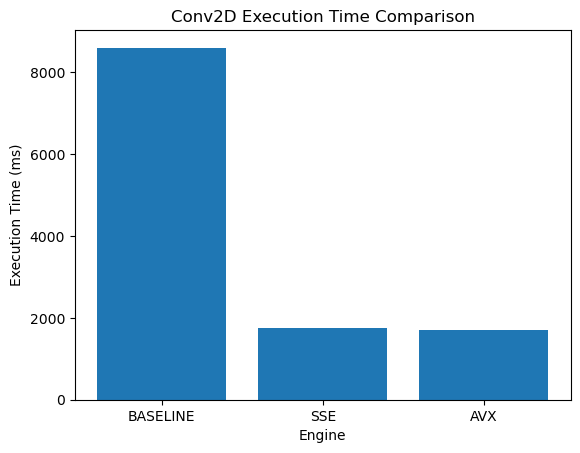

In [55]:
# Plot raw execution time

engines = list(results.keys())
times   = list(results.values())

plt.figure()
plt.bar(engines, times)
plt.ylabel("Execution Time (ms)")
plt.xlabel("Engine")
plt.title("Conv2D Execution Time Comparison")
plt.show()

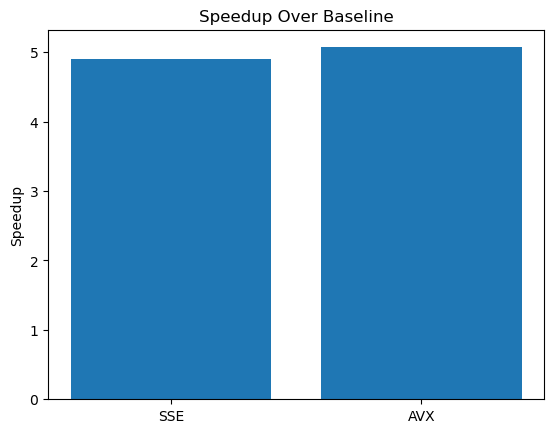

In [56]:
# Plot speedup over baseline

plt.figure()
plt.bar(["SSE", "AVX"], [speedup_sse, speedup_avx])
plt.ylabel("Speedup")
plt.title("Speedup Over Baseline")
plt.show()

### Why Is AVX Not 2× Faster Than SSE?

Although AVX uses 256-bit registers (twice the width of SSE), the measured speedups of SSE and AVX are approximately equal. This is due to several architectural and workload-related factors:

1. Memory bandwidth limitation – Conv2D with a small 3×3 kernel is memory-bound rather than compute-bound. Increasing SIMD width does not reduce memory latency.

2. Low arithmetic intensity – A small kernel performs relatively few computations per memory access, limiting the benefit of wider vectors.

3. Small dataset size – With small images, loop overhead and caching effects dominate.

Therefore, SIMD width alone does not guarantee proportional speedup. Real-world performance depends on the balance between computation, memory access, and CPU architecture behavior.